In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
import sqlite3
def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_78_00/icarus_data/database/ChannelMapICARUS_20230829.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()
    return df

def getChannelsFromBoard(board):
    geo = readSqlitedb()
    channels = geo[geo.digitizer_label==board].channel_id.to_numpy()
    return channels

def getBoardFromChannel(channel):
    geo = readSqlitedb()
    board = geo[geo.channel_id==channel].digitizer_label.values[0]
    return board

def getDigitizerChannelFromChannel(channel):
    geo = readSqlitedb()
    dig_ch = geo[geo.channel_id==channel].digitizer_ch_number.values[0]
    return dig_ch

def getChannelFromPMTid(pmt):
    geo = readSqlitedb()
    channel = geo[geo.pmt_id==pmt].channel_id.values[0]
    return channel

def getSignalCableFromChannel(channel):
    geo = readSqlitedb()
    cable = geo[geo.channel_id==channel].signal_cable_label.values[0]
    return cable

In [3]:
trig_channels = {
    "WW-TOP-A": 0x6071,
    "WW-BOT-A": 0x6061,
    "WE-TOP-A": 0x6051,
    "WE-BOT-A": 0x6041,
    "EW-TOP-A": 0x6031,
    "EW-BOT-A": 0x6021,
    "EE-TOP-A": 0x6011,
    "EE-BOT-A": 0x6001,
}
trig_channels_ = {
    0x6071:"WW-TOP-A",
    0x6061:"WW-BOT-A",
    0x6051:"WE-TOP-A",
    0x6041:"WE-BOT-A",
    0x6031:"EW-TOP-A",
    0x6021:"EW-BOT-A",
    0x6011:"EE-TOP-A",
    0x6001:"EE-BOT-A",
}

## CHECK AFTER REMOVING THE ADDITIONAL 8ns

In [5]:
fold = "/icarus/app/users/mvicenzi/OpHit/Trees-run8461_OLD_TABLE.root"
fnew = "/icarus/app/users/mvicenzi/OpHit/Trees-run8461_NEW_TABLE.root"

told = uproot.open(fold)
tnew = uproot.open(fnew)
do = told["checker/trigtree"].arrays(outputtype=pd.DataFrame, flatten=False)
dn = tnew["checker/trigtree"].arrays(outputtype=pd.DataFrame, flatten=False)
do.head()

,run,event,timestamp,trg_channel,wf_corr
entry,,,,,
0,8461,63545,1654814017,24577.0,0.176
1,8461,63545,1654814017,24577.0,0.176
2,8461,63545,1654814017,24577.0,0.176
3,8461,63545,1654814017,24577.0,0.176
4,8461,63545,1654814017,24577.0,0.176


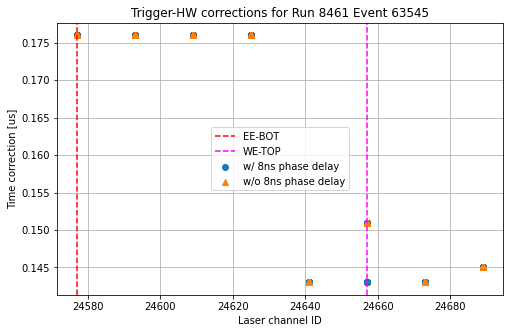

In [6]:
EVENT = 63545
fig = plt.figure(figsize=(8,5))
plt.scatter(do[do.event==EVENT].trg_channel,do[do.event==EVENT].wf_corr,label="w/ 8ns phase delay")
plt.scatter(dn[dn.event==EVENT].trg_channel,dn[dn.event==EVENT].wf_corr,label="w/o 8ns phase delay", marker="^")

plt.title("Trigger-HW corrections for Run {} Event {}".format(8461,EVENT))
plt.xlabel("Laser channel ID")
plt.ylabel("Time correction [us]")
plt.axvline(x=trig_channels["EE-BOT-A"], color="red", linestyle="dashed", label="EE-BOT")
plt.axvline(x=trig_channels["WE-TOP-A"], color="magenta", linestyle="dashed", label="WE-TOP")
plt.legend()
plt.grid()
plt.show()

In [211]:
del do; del dn
do = told["checker/ophittree"].arrays(outputtype=pd.DataFrame, flatten=False)
dn = tnew["checker/ophittree"].arrays(outputtype=pd.DataFrame, flatten=False)
do.head()

,run,event,timestamp,channel_id,tstart,tpeak,trise,tstart_corr,tpeak_corr,trise_corr,laser,cosmics,corr
entry,,,,,,,,,,,,,
0,8461,63545,1654814017,0,-872.166,-872.156,0.01,-872.420882,-872.410882,0.01,-0.253126,-0.001756,0.254882
1,8461,63545,1654814017,0,-870.916,-870.904,0.01,-871.170882,-871.158882,0.01,-0.253126,-0.001756,0.254882
2,8461,63545,1654814017,0,-870.656,-870.642,0.01,-870.910882,-870.896882,0.01,-0.253126,-0.001756,0.254882
3,8461,63545,1654814017,0,-869.442,-869.428,0.01,-869.696882,-869.682882,0.01,-0.253126,-0.001756,0.254882
4,8461,63545,1654814017,0,-863.910,-863.900,0.01,-864.164882,-864.154882,0.01,-0.253126,-0.001756,0.254882


In [212]:
wetopA = getChannelsFromBoard("WE-TOP-A")
wetopB = getChannelsFromBoard("WE-TOP-B")
wetopC = getChannelsFromBoard("WE-TOP-C")

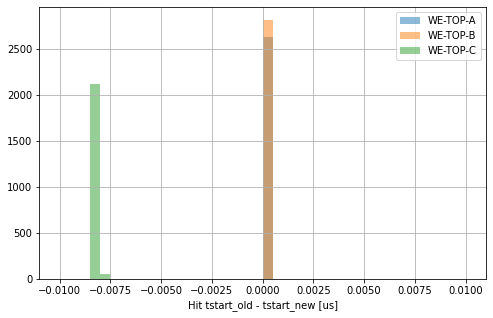

[238 239 235 236 237 230 233 234 232 231 220 223 224 222 221]


In [213]:
fig = plt.figure(figsize=(8,5))

plt.hist( do[(do.channel_id.isin(wetopA))&(do.event==EVENT)].tstart - dn[(dn.channel_id.isin(wetopA))&(dn.event==EVENT)].tstart,
          label="WE-TOP-A", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.hist( do[(do.channel_id.isin(wetopB))&(do.event==EVENT)].tstart - dn[(dn.channel_id.isin(wetopB))&(dn.event==EVENT)].tstart,
          label="WE-TOP-B", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.hist( do[(do.channel_id.isin(wetopC))&(do.event==EVENT)].tstart - dn[(dn.channel_id.isin(wetopC))&(dn.event==EVENT)].tstart,
          label="WE-TOP-C", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.xlabel("Hit tstart_old - tstart_new [us]")
plt.legend()
plt.grid()
plt.show()
print(wetopC)

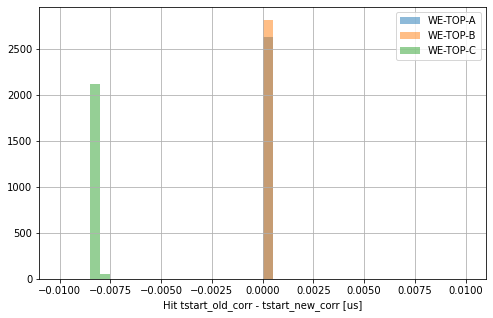

[238 239 235 236 237 230 233 234 232 231 220 223 224 222 221]


In [214]:
fig = plt.figure(figsize=(8,5))

plt.hist( do[(do.channel_id.isin(wetopA))&(do.event==EVENT)].tstart_corr - dn[(dn.channel_id.isin(wetopA))&(dn.event==EVENT)].tstart_corr,
          label="WE-TOP-A", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.hist( do[(do.channel_id.isin(wetopB))&(do.event==EVENT)].tstart_corr - dn[(dn.channel_id.isin(wetopB))&(dn.event==EVENT)].tstart_corr,
          label="WE-TOP-B", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.hist( do[(do.channel_id.isin(wetopC))&(do.event==EVENT)].tstart_corr - dn[(dn.channel_id.isin(wetopC))&(dn.event==EVENT)].tstart_corr,
          label="WE-TOP-C", range=(-0.01,0.01), bins=40, alpha=0.5 )
plt.xlabel("Hit tstart_old_corr - tstart_new_corr [us]")
plt.legend()
plt.grid()
plt.show()
print(wetopC)

## CHECK IF POSITIVE SLOPE IS RELATED TO WE-TOP

In [224]:
dump_file = "../dump_run8461.csv"
olddf = pd.read_csv(dump_file)
olddf.head()

,entry,run,event,timestamp,flash_id,flash_time,flash_y,flash_width_y,flash_z,flash_width_z,...,trackEndY,trackEndZ,trackDirX,trackDirY,trackDirZ,trackLenght,channel_id,intercept,slope,residuals
0,17,8461,63617,1654814122,3,220.21385,-33.65027,72.169685,579.89233,119.119446,...,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605,65,220.214181,0.000018,-0.009967
1,17,8461,63617,1654814122,3,220.21385,-33.65027,72.169685,579.89233,119.119446,...,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605,68,220.214181,0.000018,0.001125
2,17,8461,63617,1654814122,3,220.21385,-33.65027,72.169685,579.89233,119.119446,...,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605,69,220.214181,0.000018,0.001226
3,17,8461,63617,1654814122,3,220.21385,-33.65027,72.169685,579.89233,119.119446,...,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605,70,220.214181,0.000018,0.002957
4,17,8461,63617,1654814122,3,220.21385,-33.65027,72.169685,579.89233,119.119446,...,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605,72,220.214181,0.000018,-0.000317


In [225]:
df_pos = olddf[olddf.slope>0]
df_pos = df_pos.groupby(["run", "event", "timestamp", "cryo", "flash_id"]).agg(list)

In [226]:
a = df_pos.channel_id.to_numpy()
print("all positive slopes: {}".format(len(a)))
A, B, C = 0, 0, 0

for l in a:
    for ch in l:
        board = getBoardFromChannel(ch)
        if board == "WE-TOP-C":
                C +=1
        elif board == "WE-TOP-A":
                A += 1
        elif board == "WE-TOP-B":
                B += 1
                            
print(A, B, C)

all positive slopes: 119
87 125 56


## CHECK HOW RESIDUALS CHANGE IF +8ns TO WE-TOP-C
Use the flashana you reprocessed + old track file. Since the change is 8ns, we assume that the flashes are identical and therefore the track-flash association stays the same

In [227]:
def loadFiles( filelist, treename1, treename2, maxfiles=100, flatenndf=False):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for i,tfile in enumerate(filelist[0:maxfiles]):
        if i%10 == 0:
            print("{} files processed".format(i))
        ttree = uproot.open(tfile)
        data1 = pd.concat([data1, ttree[treename1].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
        data2 = pd.concat([data2, ttree[treename2].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
    return data1, data2

In [228]:
def getdiff( y, t):
    # max y is on top : cosmics are going towards decreasing y 
    return t[np.argmin(y)] - t[np.argmax(y)]

def fittime( y, t ):
    try:
        res= stats.linregress(y, t)
        #print( res.intercept, res.slope)
        return res.intercept,  res.slope
    except:
        return 0,0

def residuals( tobs, y, a, b ):
    return tobs -  ( a + b*y )

In [234]:
def RUN_ALL( MATCHES, FILENAMES, remove_cosmics=False, remove_laser=False):
    
    ## Get the light data and combine the two cryostats
    dfw, dfe = loadFiles(FILENAMES, "flashana/opflashCryoW_flashtree", "flashana/opflashCryoE_flashtree", 1)
    dfw["cryo"] = 1
    dfe["cryo"] = 0
    dfw.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"],inplace=True)
    dfe.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"],inplace=True)
    df = pd.concat([dfe, dfw])

    del dfw
    del dfe
    
    dfmatches = pd.read_csv(MATCHES)
    dfmatches.rename(columns={'flashID':"flash_id"}, inplace=True)
    dfmatches.set_index(["run", "event", "cryo", "flash_id"], inplace=True)
    df = (df.join( dfmatches, on=["run", "event", "cryo", "flash_id"], how='inner'))
    df["channel_id"] = df.pmt_y.apply( lambda x : np.arange(len(x)) )

    print("Consider {} tracks".format( len(df) ) )
    
    ## Explode the dataframe 
    df = df.explode(["time_pmt", "pmt_x", "pmt_y", "pe_pmt", "pmt_z", "amplitude_pmt","channel_id"])
    
    if ( remove_cosmics ):
        COSMICSCORR = "../output/residuals/FINAL/cosmics_timing_residuals_t8046_offpmts_20230727.csv"
        cosmics = pd.read_csv(COSMICSCORR).set_index("channel_id")
        df = df.join( cosmics["mean_residual_ns"], on="channel_id" )
        df["time_pmt"] = df["time_pmt"]+df["mean_residual_ns"]/1e3 #convert ns to us
        
    _pecut=300

    _sel = (df.pe_pmt > _pecut)
    meandf = df[_sel][["run", "event", "cryo", "flash_id", "time_pmt", "pe_pmt", "pmt_y"]].groupby(["run", "event", "cryo", "flash_id", "pmt_y"]).apply( 
        lambda x : pd.Series( {
        "mean_time" : np.mean(x.time_pmt),
        "weight_mean_time" : np.average(x.time_pmt, weights=x.pe_pmt), 
        "error_mean_time": np.std(x.time_pmt) / np.sqrt(len(x.time_pmt)),
    }) ).reset_index()

    meandf = meandf.groupby(["run", "event", "cryo", "flash_id"]).agg(list)

    print("PE cut leaves {} tracks".format( len(meandf) ))
    
    meandf["diff_time"] = meandf.apply( lambda x : getdiff( x.pmt_y, x.mean_time ), axis=1 ) 
    meandf[["intercept", "slope"]] = meandf.apply(lambda x : fittime(x.pmt_y, x.mean_time ), axis=1, result_type="expand" )
    
    dfg = df.join( meandf[["intercept", "slope"]], on=["run", "event", "cryo", "flash_id"], how='inner')
    dfg["residuals"] = dfg.apply( lambda x : residuals(x.time_pmt, x.pmt_y, x.intercept, x.slope), axis=1 ) 

    # Keep only the residuals on relevant PMT for that event
    PECUT = 300
    dfg = dfg[(dfg.pe_pmt>PECUT)]
    
    us_to_ns = 1e3
    thisdfg = dfg.groupby(["channel_id"]).apply(
    lambda x : pd.Series( { 
            'x': np.mean(x.pmt_x),
            'y': np.mean(x.pmt_y),
            'z': np.mean(x.pmt_z),
            'entries' : len(x.residuals), 
            'pecut' : PECUT,
            'mean_residual_ns' : np.mean(x.residuals)*us_to_ns,
            'std_residual_ns' : np.std(x.residuals)*us_to_ns,
            'emean_ns' : np.std(x.residuals)*us_to_ns/len(x.residuals)
        })).reset_index()
    
    return thisdfg, meandf

In [249]:
MATCHES = "../output/run8461_matched_light_tracks.txt"
FILENAMES = [ "/icarus/app/users/mvicenzi/OpHit/Trees-run8461_OLD_TABLE.root" ]

df_old, meandf_old = RUN_ALL(MATCHES, FILENAMES, remove_cosmics=True)

0 files processed
Consider 39 tracks
PE cut leaves 39 tracks


In [250]:
MATCHES = "../output/run8461_matched_light_tracks.txt"
FILENAMES = [ "/icarus/app/users/mvicenzi/OpHit/Trees-run8461_NEW_TABLE.root" ]

df_new, meandf_new = RUN_ALL(MATCHES, FILENAMES, remove_cosmics=True)

0 files processed
Consider 39 tracks
PE cut leaves 39 tracks


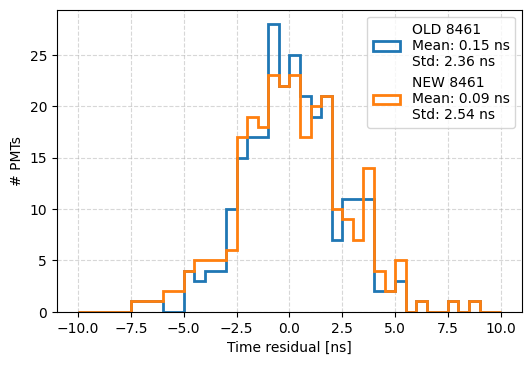

In [251]:
# Plotting full distribution 
fig = plt.figure(dpi=100)

rmin=-10
rmax=10
r=(rmin,rmax)
s=0.5
b=int((rmax-rmin)/s)

resold = df_old.mean_residual_ns.to_numpy()
resnew = df_new.mean_residual_ns.to_numpy()


labold = "OLD {}\nMean: {:.2f} ns\nStd: {:.2f} ns".format(8461,np.mean(resold),np.std(resold))
labnew = "NEW {}\nMean: {:.2f} ns\nStd: {:.2f} ns".format(8461,np.mean(resnew),np.std(resnew))


plt.hist(resold, bins=b, linewidth=2, range=r, histtype="step", label=labold)
plt.hist(resnew, bins=b, linewidth=2, range=r, histtype="step", label=labnew)

plt.xlabel("Time residual [ns]")
plt.ylabel("# PMTs")
plt.legend()
plt.grid(linestyle="dashed", alpha=0.5)

In [252]:
oldslopes = meandf_old["slope"].values
newslopes = meandf_new["slope"].values

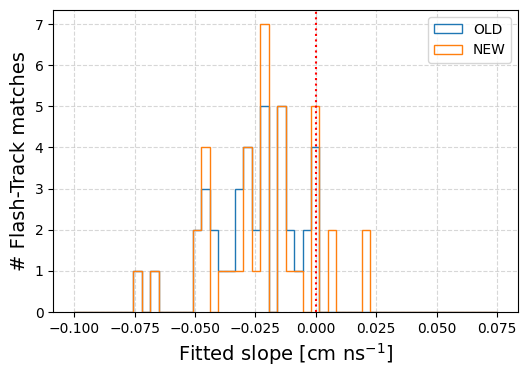

In [253]:
fig = plt.figure(dpi=100)

plt.hist( oldslopes*1e3, bins=50, range=(-0.1,0.075), histtype='step', label="OLD")
plt.hist( newslopes*1e3, bins=50, range=(-0.1,0.075), histtype='step', label="NEW")
plt.ylabel("# Flash-Track matches", fontsize=14)
plt.xlabel("Fitted slope [cm ns$^{-1}$]", fontsize=14)

plt.axvline(x=0.,color="red",linestyle="dotted")

#plt.tight_layout()
plt.grid(linestyle="dashed",alpha=0.5)
plt.legend()
plt.show()

In [5]:
file = "../output/residuals/FINAL/cosmics_timing_residuals_t8046_offpmts_20230727.csv"
res = pd.read_csv(file)

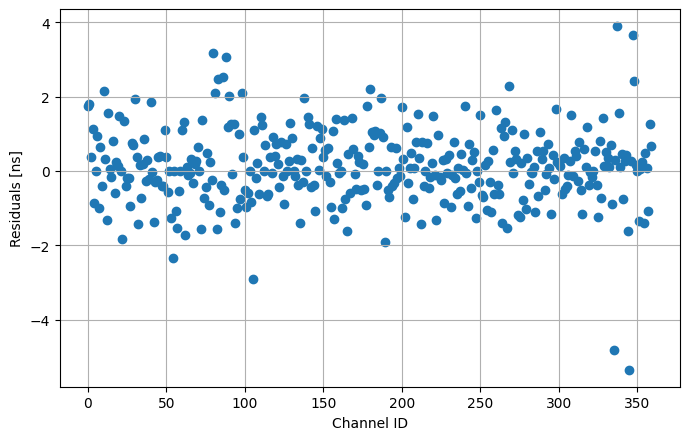

In [7]:
fig = plt.figure(figsize=(8,5),dpi=100)
plt.scatter( res.channel_id, res.mean_residual_ns )
plt.grid()
plt.xlabel("Channel ID")
plt.ylabel("Residuals [ns]")
plt.show()